In [1]:
import numpy as np
import os
import pyarrow
import sys
import json
import math
import mpl_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import polars as pl
import xml.etree.ElementTree as ET

from xopen import xopen

In [2]:
# General directories
general_directory = '/Users/andre/Desktop/Cergy/'

berlin_directory = 'MATSim/matsim-berlin/input/v6.4/'

dt_choice_dir = "Python_Scripts/runs/dt_choice/"

In [3]:
# MATSim Berlin paths
PLAN_PATH = (os.path.join(general_directory, berlin_directory, "parquet/MATSim_trips.parquet")) # MATSim trips

METRO_OUTPUT = (os.path.join(general_directory, dt_choice_dir, "metro_outputs/"))

EVENTS_PATH = ((os.path.join(general_directory, berlin_directory, "parquet/")))



In [4]:
sys.path.append("../../functions")
import Demand_functions as dmd
import Supply_functions as sup

## Read Files

In [5]:
def read_matsim_plans():
    matsim_trips = pl.read_parquet(os.path.join(PLAN_PATH))
    return matsim_trips

In [6]:
def read_metropolis_results():
    agents = pl.read_parquet(os.path.join(METRO_OUTPUT, "agent_results.parquet"))
    trips = pl.read_parquet(os.path.join(METRO_OUTPUT, "trip_results.parquet"))
    routes = pl.read_parquet(os.path.join(METRO_OUTPUT, "route_results.parquet"))
    return agents, trips, routes

In [7]:
print("Reading MATSim experienced plans")
matsim_trips = read_matsim_plans()

Reading MATSim experienced plans


In [8]:
print("Reading METROPOLIS results")
mp_agents, mp_trips, mp_routes = read_metropolis_results()

Reading METROPOLIS results


# Add `output_events` departure and arrival times

## Event times

In [9]:
event_times = pl.read_parquet(os.path.join(EVENTS_PATH, "departure_arrival.parquet"))

In [10]:
event_times = (
    event_times
    .sort(pl.col(["vehicle","time", "link_id"]))
    .with_columns(pl.int_range(0, pl.len()).over("vehicle", "link_id").alias("index"))
)
event_times = event_times.sort(pl.col('vehicle', 'time', 'index', 'link_id'))

In [11]:
departures = (
    event_times
    .filter(pl.col("event_type") == "departure")
    .rename({"time": "dep_time",
             "vehicle": "person_id",
             "link_id":"start_link"})
    .drop(["event_type", 'index'])
)


arrivals = (
    event_times
    .filter(pl.col("event_type") == "arrival")
    .rename({"time":"arr_time",
             "vehicle":"person_id",
             "link_id":"end_link"}
           ) 
    .drop(["event_type", 'index'])
)

In [12]:
# Ordenar y asignar trip_id según el orden de tiempo por persona
departures = departures.sort(["person_id", "dep_time"]).with_columns(
    pl.cum_count("person_id").over("person_id").alias("trip_id")
)

arrivals = arrivals.sort(["person_id", "arr_time"]).with_columns(
    pl.cum_count("person_id").over("person_id").alias("trip_id")
)
trip_times = departures.join(arrivals, on=["person_id", "trip_id"], how="inner")

In [13]:
matsim_trips= (
    matsim_trips
    .join(trip_times, on=["person_id", 'trip_id', 'start_link', 'end_link'], how='inner')
    .select(['person_id', 'plan_id', 'trip_id', 'mode', 'start_link', 'end_link', 'route',
             'dep_time', 'arr_time', 'start_time', 'end_time', 'stopping_time']))

In [14]:
mp_trips = (
    mp_trips
    .with_columns([(pl.col('arrival_time') - pl.col('departure_time')).alias('travel_time')])
)

# Comparison table

In [15]:
comparison_table = (
    matsim_trips
    .select(["plan_id", "trip_id", "mode", "dep_time", "arr_time",
            ])
    .join(
        mp_trips.select(["agent_id", "trip_id", "departure_time", "arrival_time", 'travel_time',
                         "route_free_flow_travel_time", "in_bottleneck_time"]),
        left_on=["plan_id", "trip_id"], right_on=['agent_id', "trip_id"],
        how="inner")
    .rename({'plan_id':'agent_id'})
)
comparison_table = comparison_table.with_columns([
    (pl.col("arr_time") - pl.col("dep_time")).alias("trav_time"), # MATSim events 
    (pl.col("departure_time") - pl.col("dep_time")).alias("start_diff"),
    (pl.col("arrival_time") - pl.col("arr_time")).alias("end_diff")
    #(pl.col("start_time") - pl.col("dep_time")).alias("matsim_dep_diff"),
    #(pl.col("end_time") - pl.col("arr_time")).alias("matsim_arr_diff")
])

In [16]:
car_comparison = comparison_table.filter(
    pl.col('mode').is_in(['car', 'ride'])
)

In [17]:
car_comparison = (
    car_comparison
    .with_columns([(pl.col('trav_time')-pl.col('route_free_flow_travel_time')).alias('ms_congestion_time')])
    .drop(['mode', 'dep_time', 'arr_time', 'departure_time', 'arrival_time', 
           'start_diff', 'end_diff'])
)

# Departure_time

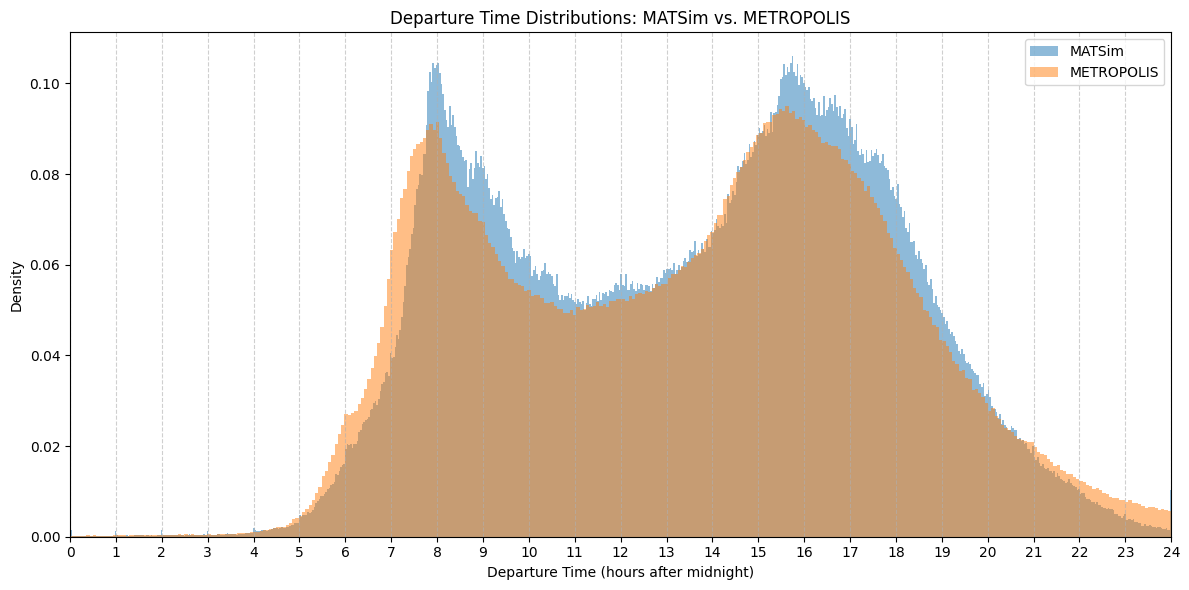

In [18]:
plt.figure(figsize=(12, 6))

# Plot MATSim departure times
plt.hist(comparison_table['dep_time'] / 3600, bins=1000, alpha=0.5, density=True, label='MATSim')

# Plot METROPOLIS departure times
plt.hist(comparison_table['departure_time'] / 3600, bins=1000, alpha=0.5, density=True, label='METROPOLIS')

# Set limits and ticks
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 1))  # Hourly ticks from 0 to 24

plt.xlabel('Departure Time (hours after midnight)')
plt.ylabel('Density')
plt.title('Departure Time Distributions: MATSim vs. METROPOLIS')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# For the First departure time

In [19]:
compraison_first_departures = (
    comparison_table
    .filter(pl.col('trip_id')==1)
    .sort('agent_id')
    .select(['agent_id', 'dep_time', 'departure_time'])
    .with_columns([
        ((pl.col('dep_time')-pl.col('departure_time'))/60).alias('earl_dep_diff_min')
    ])
)

In [20]:
compraison_first_departures['earl_dep_diff_min'].describe()

statistic,value
str,f64
"""count""",474751.0
"""null_count""",0.0
"""mean""",14.66748
"""std""",23.732729
"""min""",-1229.707189
"""25%""",-0.16186
"""50%""",14.239859
"""75%""",31.448438
"""max""",568.759676


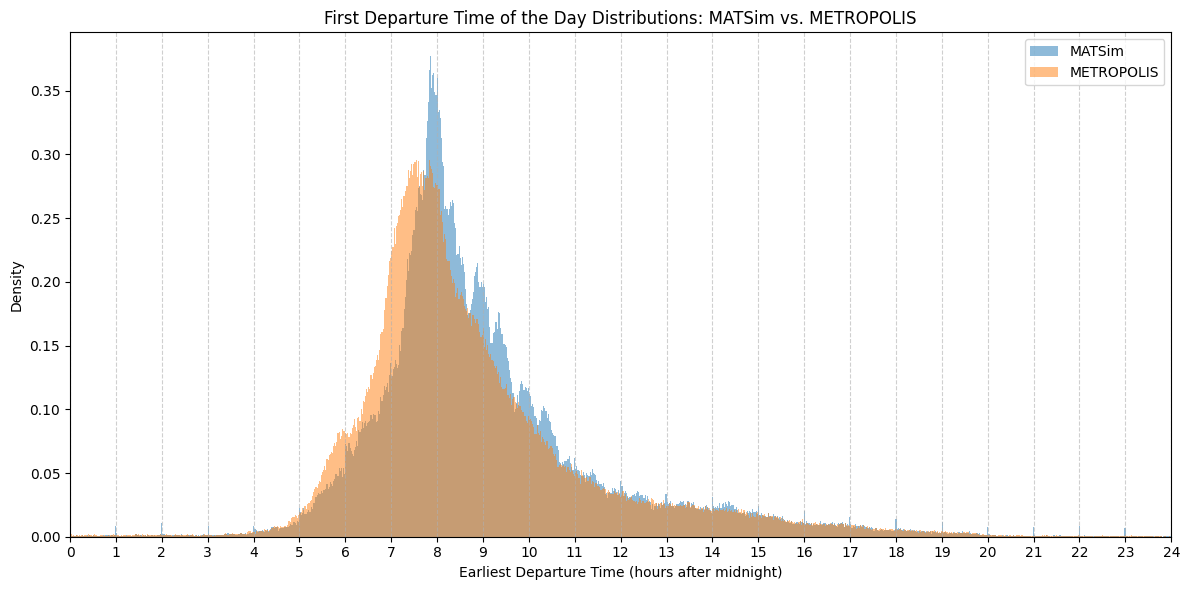

In [21]:
plt.figure(figsize=(12, 6))

# Plot MATSim departure times
plt.hist(compraison_first_departures['dep_time'] / 3600, bins=1000, alpha=0.5, density=True, label='MATSim')

# Plot METROPOLIS departure times
plt.hist(compraison_first_departures['departure_time'] / 3600, bins=1000, alpha=0.5, density=True, label='METROPOLIS')

# Set limits and ticks
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 1))  # Hourly ticks from 0 to 24

plt.xlabel('Earliest Departure Time (hours after midnight)')
plt.ylabel('Density')
plt.title('First Departure Time of the Day Distributions: MATSim vs. METROPOLIS')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Initial MATSim Input Plans Departures

In [22]:
#initial_departures = dmd.get_initial_dep_times(DEPARTURES_PATH) # 5 minutes
initial_departures = pl.read_parquet(os.path.join(EVENTS_PATH, 'initial_departures.parquet'))
initial_departures = initial_departures.with_columns([dmd.hhmmss_str_to_seconds_expr(('dep_time'))
                                                     ]).rename({'plan_id':'agent_id',
                                                                'dep_time_secs': 'init_dep_time'})

In [23]:
compraison_first_departures=compraison_first_departures.join(
    initial_departures.select(['agent_id', 'init_dep_time']), on='agent_id')

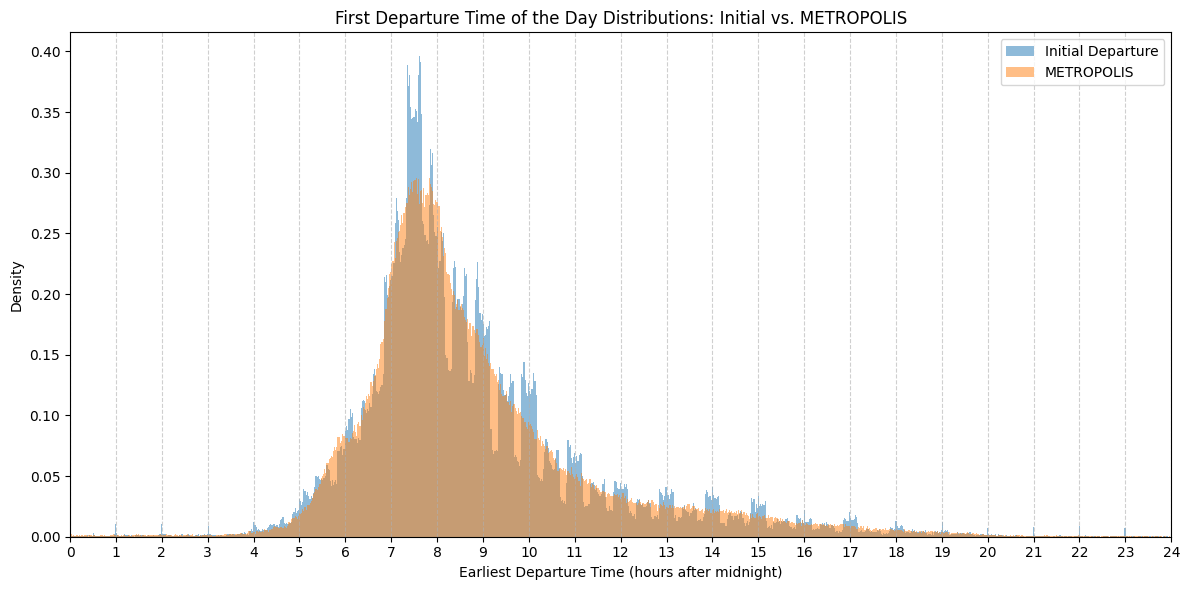

In [24]:
plt.figure(figsize=(12, 6))

# Plot MATSim departure times
plt.hist(compraison_first_departures['init_dep_time'] / 3600, bins=1000, alpha=0.5, density=True, 
         label='Initial Departure')

# Plot METROPOLIS departure times
plt.hist(compraison_first_departures['departure_time'] / 3600, bins=1000, alpha=0.5, density=True, 
         label='METROPOLIS')

# Set limits and ticks
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 1))  # Hourly ticks from 0 to 24

plt.xlabel('Earliest Departure Time (hours after midnight)')
plt.ylabel('Density')
plt.title('First Departure Time of the Day Distributions: Initial vs. METROPOLIS')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

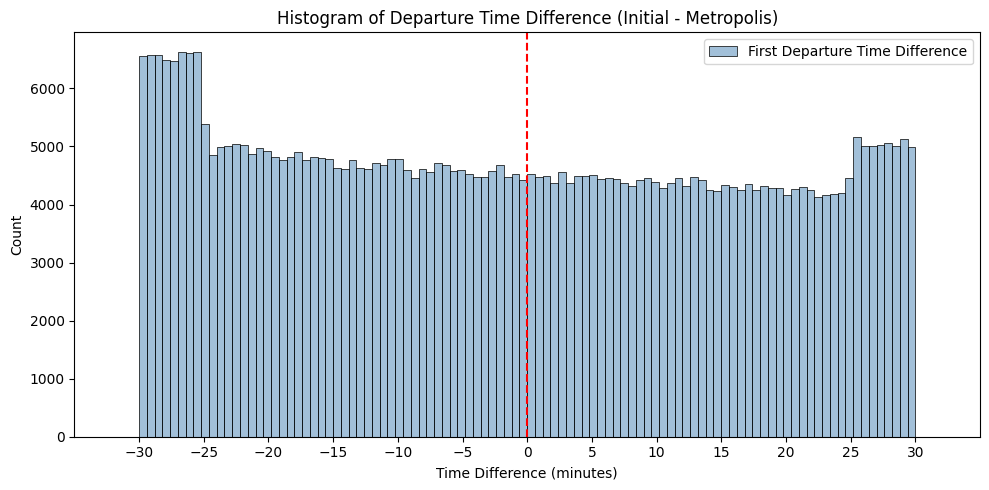

In [25]:
xticks = np.arange(-30, 31, 5)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(
    (compraison_first_departures['init_dep_time'] - compraison_first_departures['departure_time'])/60,
    bins=100,
    alpha=0.5,
    color="steelblue",
    kde=False,
    label="First Departure Time Difference"
)

# Line in 0
plt.axvline(0, color="red", linestyle="--")

plt.xlim(-35, 35)
plt.xticks(xticks)
plt.title("Histogram of Departure Time Difference (Initial - Metropolis)")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Dep_time difference

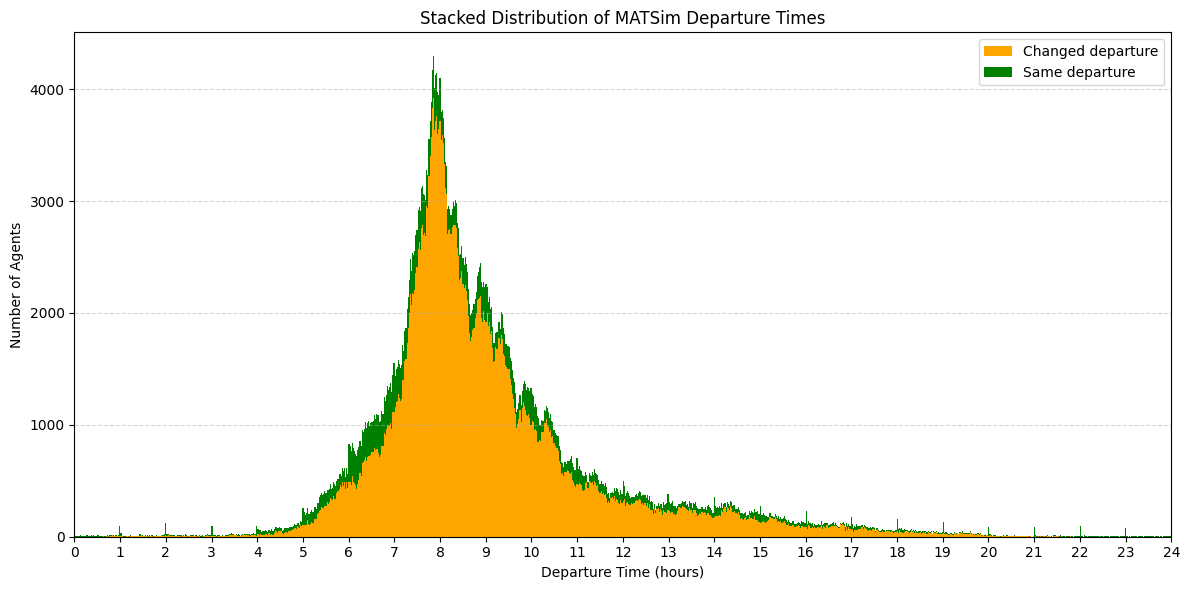

In [52]:
# Separate into 2 data frames
same_dep = compraison_first_departures.filter((pl.col("dep_time") - pl.col("init_dep_time")).abs() <= 300)
changed_dep = compraison_first_departures.filter((pl.col("dep_time") - pl.col("init_dep_time")).abs() > 300)


plt.figure(figsize=(12, 6))
plt.hist([changed_dep["dep_time"]/ 3600, same_dep["dep_time"]/ 3600], # in hours
         bins=1000,  # 30-minute bins
         histtype="barstacked",
         color=["orange", "green"],
         label=["Changed departure", "Same departure"])

plt.xlim(0, 24)
plt.xticks(range(0, 25, 1))
plt.xlabel("Departure Time (hours)")
plt.ylabel("Number of Agents")
plt.title("Stacked Distribution of MATSim Departure Times")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

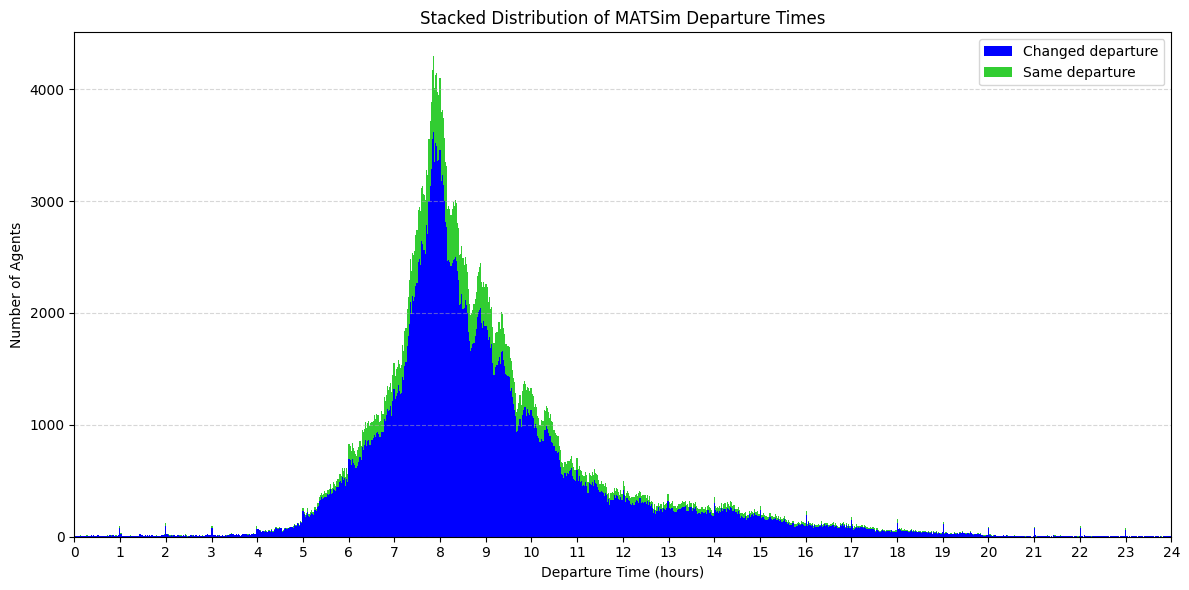

In [54]:
# Separate into 2 data frames
same_dep_mp = compraison_first_departures.filter((pl.col("departure_time") - pl.col("init_dep_time")).abs() <= 300)
changed_dep_mp = compraison_first_departures.filter((pl.col("departure_time") - pl.col("init_dep_time")).abs() > 300)


plt.figure(figsize=(12, 6))
plt.hist([changed_dep_mp["dep_time"]/ 3600, same_dep_mp["dep_time"]/ 3600], # in hours
         bins=1000,  # 30-minute bins
         histtype="barstacked",
         color=["blue", "limegreen"],
         label=["Changed departure", "Same departure"])

plt.xlim(0, 24)
plt.xticks(range(0, 25, 1))
plt.xlabel("Departure Time (hours)")
plt.ylabel("Number of Agents")
plt.title("Stacked Distribution of MATSim Departure Times")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [26]:
comparison_table=(
    comparison_table
    .with_columns([
        ((pl.col('dep_time') - pl.col('departure_time'))/60).alias('dep_time_diff_min')
    ])
)

In [27]:
comparison_table['dep_time_diff_min'].describe()

statistic,value
str,f64
"""count""",4.991867e6
"""null_count""",0.0
"""mean""",-26.79069
"""std""",182.008483
"""min""",-2891.570206
"""25%""",-8.674436
"""50%""",9.131943
"""75%""",28.400386
"""max""",598.063896


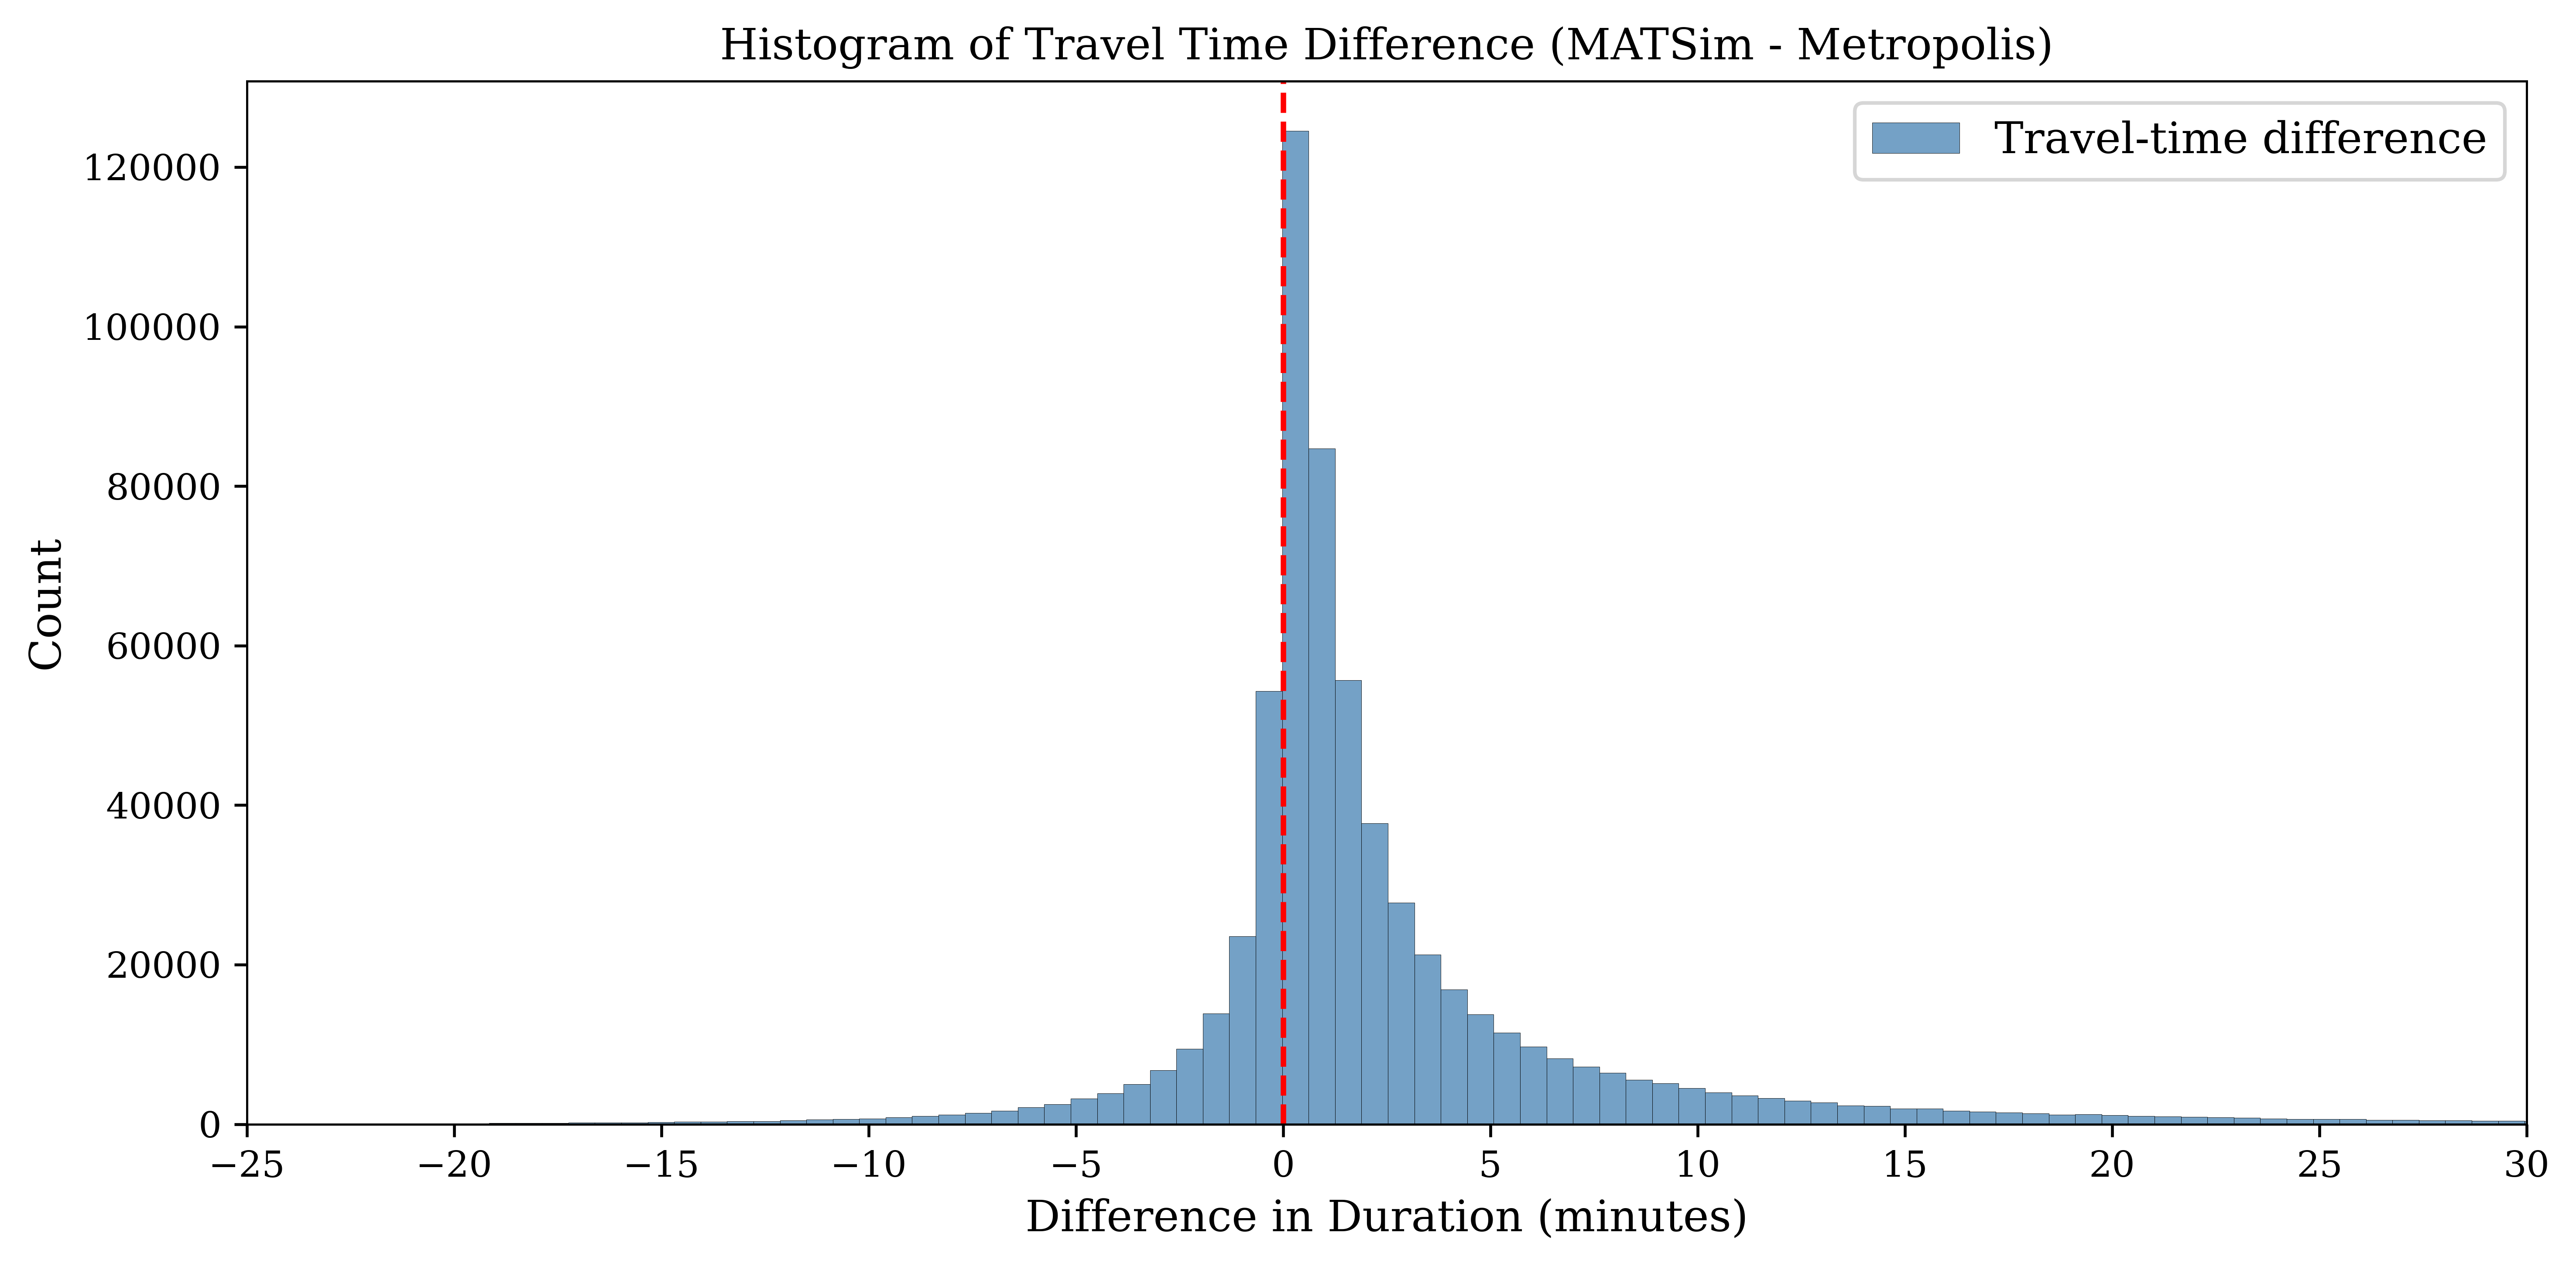

In [34]:
# Crear marcas del eje x cada 2.5 minutos
xticks = np.arange(-25, 31, 5)

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(
    df_pd["diff_min"],
    bins=500,
    color="steelblue",
    kde=False,
    label="Travel-time difference"
)

# Línea en 0
plt.axvline(0, color="red", linestyle="--")

# Configuración de ejes
plt.xlim(-17, 30)
plt.xticks(xticks)
plt.title("Histogram of Travel Time Difference (MATSim - Metropolis)")
plt.xlabel("Difference in Duration (minutes)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()